In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('city_day.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

#['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene','AQI']

In [6]:
print(df.isnull().sum())

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
DayOfYear         0
Month             0
Year              0
dtype: int64


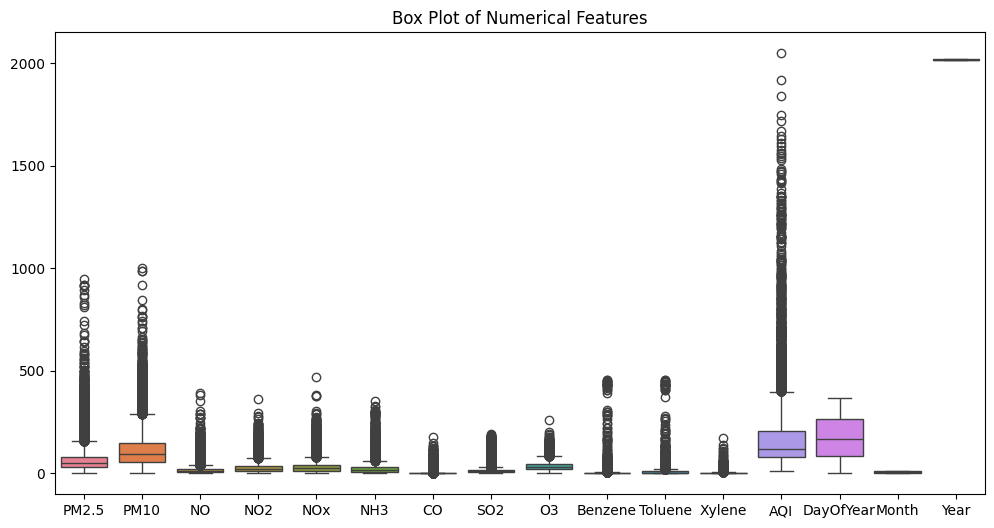

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot for each numerical column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Numerical Features')
plt.show()

In [8]:
df = df.drop(columns=['NH3', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'], axis=1)

In [9]:
columns_to_fill = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())


In [10]:
df.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,DayOfYear,Month,Year
0,Ahmedabad,2015-01-01,67.450578,118.127103,0.92,18.22,17.15,0.92,27.64,133.36,0.00,1,1,2015
1,Ahmedabad,2015-01-02,67.450578,118.127103,0.97,15.69,16.46,0.97,24.55,34.06,3.68,2,1,2015
2,Ahmedabad,2015-01-03,67.450578,118.127103,17.40,19.30,29.70,17.40,29.07,30.70,6.80,3,1,2015
3,Ahmedabad,2015-01-04,67.450578,118.127103,1.70,18.48,17.97,1.70,18.59,36.08,4.43,4,1,2015
4,Ahmedabad,2015-01-05,67.450578,118.127103,22.10,21.42,37.76,22.10,39.33,39.31,7.01,5,1,2015


In [11]:
cities = df['City'].unique()
cities_to_index = {city: index for index, city in enumerate(cities)}
df['CityIndex'] = df['City'].map(cities_to_index)
num_cities= len(cities)

In [12]:
df.head(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,DayOfYear,Month,Year,CityIndex
0,Ahmedabad,2015-01-01,67.450578,118.127103,0.92,18.22,17.15,0.92,27.64,133.36,0.00,1,1,2015,0
1,Ahmedabad,2015-01-02,67.450578,118.127103,0.97,15.69,16.46,0.97,24.55,34.06,3.68,2,1,2015,0
2,Ahmedabad,2015-01-03,67.450578,118.127103,17.40,19.30,29.70,17.40,29.07,30.70,6.80,3,1,2015,0
3,Ahmedabad,2015-01-04,67.450578,118.127103,1.70,18.48,17.97,1.70,18.59,36.08,4.43,4,1,2015,0
4,Ahmedabad,2015-01-05,67.450578,118.127103,22.10,21.42,37.76,22.10,39.33,39.31,7.01,5,1,2015,0


In [13]:
def create_sequences(data, city_data, seq_length):
    X, y, X_city = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :len(features)])
        X_city.append(city_data[i + seq_length])
    return np.array(X), np.array(y), np.array(X_city)

seq_length = 30
features = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']
X, y, X_city = create_sequences(df[features + ['DayOfYear', 'Month', 'Year']].values,
                                   df['CityIndex'].values,
                                   seq_length)

X_city = to_categorical(X_city, num_classes=num_cities)
X_train, X_test, y_train, y_test, X_city_train, X_city_test = train_test_split(X, y, X_city, test_size=0.2, random_state=42)


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam

# Define Vanilla LSTM model
def create_vanilla_lstm_model(seq_length, num_features, num_cities, num_pollutants):
    # Input for the time series sequence data
    input_seq = Input(shape=(seq_length, num_features))

    # Input for the city information
    input_city = Input(shape=(num_cities,))

    # LSTM layer for sequence processing
    x = LSTM(64, return_sequences=False)(input_seq)

    # Concatenate the output of LSTM with city information
    x = Concatenate()([x, input_city])

    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Output layer for predicting 9 pollutants
    output = Dense(num_pollutants, activation='linear')(x)

    # Define the model with both inputs
    model = tf.keras.Model(inputs=[input_seq, input_city], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse'])

    return model

# Define hyperparameters
num_features = len(features) + 3  # features + 'DayOfYear', 'Month', 'Year'
num_pollutants = 9  # Number of pollutants to predict

# Create the model
model = create_vanilla_lstm_model(seq_length, num_features, num_cities, num_pollutants)

# Train the model
history = model.fit([X_train, X_city_train], y_train, epochs=100, batch_size=32, validation_data=([X_test, X_city_test], y_test))

# Predicting pollutant concentrations for a specific future date and city
def predict_pollutants(model, X, X_city):
    predictions = model.predict([X, X_city])
    return predictions

# Example prediction for test data
predicted_pollutants = predict_pollutants(model, X_test, X_city_test)

# Display the first few predictions
print(predicted_pollutants[:5])


Epoch 1/100


c:\Users\sunha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_11', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(


738/738 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1888.7791 - mse: 1888.7791 - val_loss: 788.0063 - val_mse: 788.0063
Epoch 2/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 777.3655 - mse: 777.3655 - val_loss: 717.9431 - val_mse: 717.9431
Epoch 3/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 743.5182 - mse: 743.5182 - val_loss: 724.2047 - val_mse: 724.2047
Epoch 4/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 679.5774 - mse: 679.5774 - val_loss: 683.8563 - val_mse: 683.8563
Epoch 5/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 654.5366 - mse: 654.5366 - val_loss: 689.9045 - val_mse: 689.9045
Epoch 6/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 672.6014 - mse: 672.6014 - val_loss: 612.0903 - val_mse: 612.0903
Epoch 7/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 587.5104 - mse: 587.5104 - val_loss: 600.1469 - val_mse: 600.1469
Epoch 8/100
738/738 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 582.7231 - mse: 582.7231 - val_loss: 567.2045 - val_mse: 567

In [15]:
model.save('cd2.h5')

In [16]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Load the saved model
model = load_model('cd2.h5', custom_objects={'mse': 'mean_squared_error'})

# Evaluate the model on the test set
test_loss, test_mse = model.evaluate([X_test, X_city_test], y_test)
print(f"Test Loss: {test_loss}, Test MSE: {test_mse}")

# Function to predict pollutants for a future date and city
def predict_pollutants_for_date(model, future_date, city, seq_length, features, city_to_index):
    # Create input data for the given future date and city
    # Assume that you have historical data to create the sequence
    historical_data = df[df['City'] == city].tail(seq_length)  # Get the last 'seq_length' rows for that city
    
    # Prepare the sequence input and city input
    if len(historical_data) < seq_length:
        print(f"Not enough historical data for city: {city} to predict for {future_date}.")
        return
    
    sequence_input = historical_data[features + ['DayOfYear', 'Month', 'Year']].values
    city_index = city_to_index[city]
    
    # Create the input arrays
    X_input = np.array([sequence_input])
    X_city_input = np.zeros((1, len(city_to_index)))
    X_city_input[0, city_index] = 1  # One-hot encode the city index

    # Make predictions
    predicted_pollutants = model.predict([X_input, X_city_input])

    # Display the predicted concentrations
    print(f"Predicted pollutant concentrations for {city} on {future_date}:")
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene']
    for pollutant, concentration in zip(pollutants, predicted_pollutants[0]):
        print(f"{pollutant}: {concentration:.2f}")

# Example usage
future_date = pd.Timestamp('2025-10-05')
city = 'Chennai'

# Create a mapping from city names to their indices (one-hot encoding)
city_to_index = {city_name: index for index, city_name in enumerate(df['City'].unique())}

predict_pollutants_for_date(model, future_date, city, seq_length, features, city_to_index)


c:\Users\sunha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 481.9195 - mean_squared_error: 481.9195
Test Loss: 480.6636962890625, Test MSE: 480.6636962890625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted pollutant concentrations for Chennai on 2025-10-05 00:00:00:
PM2.5: 33.22
PM10: 53.83
NO: 10.88
NO2: 15.25
NOx: 22.03
CO: 0.60
SO2: 6.69
O3: 27.47
Benzene: 1.52


c:\Users\sunha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

# Evaluate the model on the test set
test_loss, test_mse = model.evaluate([X_test, X_city_test], y_test)
print(f"Test Loss: {test_loss}, Test MSE: {test_mse}")

# Get predictions on the test set
predicted_pollutants = model.predict([X_test, X_city_test])

# Assuming pollutants are treated as classes for F1 score calculation
# Binarize the predictions and ground truth based on a threshold (e.g., > 0)
threshold = 0.5  # Adjust threshold as needed

# Binarize predictions and true values
predicted_classes = (predicted_pollutants > threshold).astype(int)
true_classes = (y_test > threshold).astype(int)

# Calculate F1 score
f1_scores = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)
print(f"F1 Score: {f1_scores}")


# Calculate RMSE for additional evaluation
rmse = np.sqrt(mean_squared_error(y_test, predicted_pollutants))
print(f"Root Mean Squared Error (RMSE): {rmse}")


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 481.9195 - mean_squared_error: 481.9195
Test Loss: 480.6636962890625, Test MSE: 480.6636962890625
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
F1 Score: 0.9625265551163865
Root Mean Squared Error (RMSE): 21.92404678579629


### choice - boosters:

In [19]:
from tensorflow.keras.models import load_model
import xgboost as xgb
import numpy as np

# Load the saved Vanilla LSTM model
lstm_model = load_model('cd2.h5', custom_objects={'mse': 'mean_squared_error'})


# Use the LSTM model to extract features from the training and test data
# Assume X_train and X_test are the original data in the required format for the LSTM model
lstm_features_train = lstm_model.predict([X_train, X_city_train])
lstm_features_test = lstm_model.predict([X_test, X_city_test])


  1/738 ━━━━━━━━━━━━━━━━━━━━ 1:29 121ms/step

c:\Users\sunha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


738/738 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [21]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid for randomized search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10, 12],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],  # L1 regularization
    'reg_lambda': [1, 0.1, 0.01, 0.001],  # L2 regularization
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV to search for the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,  # Number of different combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model using the LSTM features
random_search.fit(lstm_features_train, y_train)

# Get the best model from the search
best_xgb_model = random_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_xgb_model.predict(lstm_features_test)

# Calculate the RMSE with the tuned model
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Optimized Root Mean Squared Error (RMSE) with XGBoost: {best_rmse}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Optimized Root Mean Squared Error (RMSE) with XGBoost: 20.83960432258618


In [23]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Parameter grid for RandomizedSearchCV
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 0.5, 0.1, 0.01]
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search model
random_search_xgb.fit(lstm_features_train, y_train)
best_xgb_model = random_search_xgb.best_estimator_

print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid for RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search model
random_search_rf.fit(lstm_features_train, y_train)
best_rf_model = random_search_rf.best_estimator_

print(f"Best parameters for RandomForestRegressor: {random_search_rf.best_params_}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for RandomForestRegressor: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': True}


In [27]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the GradientBoostingRegressor with default parameters
gb_model = GradientBoostingRegressor(random_state=42)

# Wrap the regressor with MultiOutputRegressor to handle multi-output targets
multi_output_gb = MultiOutputRegressor(gb_model)

# Fit the MultiOutputRegressor with GradientBoostingRegressor to the training data
multi_output_gb.fit(lstm_features_train, y_train)

# Make predictions on the test set
y_pred_multi_gb = multi_output_gb.predict(lstm_features_test)

# Calculate the RMSE for the multi-output predictions
multi_output_rmse = np.sqrt(mean_squared_error(y_test, y_pred_multi_gb))
print(f"Multi-Output Gradient Boosting Regressor RMSE: {multi_output_rmse}")


Multi-Output Gradient Boosting Regressor RMSE: 20.96311536337177
